# Игры — Формирование модели монетизации

<a id="step_start"></a>
### Оглавление 

1. [Описание задачи и датасетов](#step0)   
2. [Загрузка и обзор данных](#step1)   
    2.1. [Итоги обзора и предобработки данных](#step1-1)    
3. [Исследовательский анализ данных, EDA](#step2)   
    3.1. [Итоги EDA](#step2-1)    
4. [Анализ поведения игроков](#step3)   
    4.1. [Портреты игроков](#step3-0)    
    4.2. [Результаты проверки гипотез](#hypothesis)   
    4.2. [Анализ Retention Rate и Churn Rate по когортам](#retention)       
    4.1. [Результаты анализа поведения игроков и проверки гипотез](#step3-1)      
5. [Анализ расходов и возможных путей монетизации](#step4)   
6. [Общие выводы ](#step4-1)      
    

<a id="step1"></a>
### Этап 1: загрузка и обзор данных
[К оглавлению](#step_start)  
1. Корректно загрузить данные;
2. Проверить имена и переименовать по необходимости;
3. проверить типы данных и откорректировать при необходимости;
4. Проверить данные на дубликаты;
5. Проверить пропуски в данных - наличие, структура, поиск закономерностей.

In [1]:
#общий импорт для аналитических целей
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#для статистических тестов
from scipy import stats as st
from sklearn import preprocessing

In [2]:
#функция для массового вывода подсчета количества значений, удобно для осмотра категориальных переменных
def count_values_in_columns(df, Columns):
    '''
    для датафрейма df выводит счетчики значений value_counts по списку колонок (с учетом NA)
    '''
    for Column in Columns:
        print (Column)
        print (df[Column].value_counts(dropna=False))
        print ('=======================================')   
def describe_col(data, desc_by, col_list, metrics_list=['mean', 'std', 'min', 'max']):
    '''Выводит описательные метрики в разрезе по категориальному признаку по списку колонок

    data - датафрейм 
    desc_by - в каком разрезе выводить признаки, аналогично columns в pivot_table
    col_list - список колонок, пойдут в индекс строк первого порядка
    metrics_list - список метрик, поддерживаемых методом describe(), пойдут в индекс строк второго порядка. '''
    curr_option = pd.options.display.max_rows
    pd.set_option('display.max_rows',None)
    temp_df = data.groupby(desc_by)[col_list].describe().T
    print(temp_df[temp_df.index.isin(metrics_list, level=1)])
    pd.set_option('display.max_rows',curr_option)

In [3]:
path_events = 'datasets/game_actions.csv'
path_costs = 'datasets/ad_costs.csv'
path_source = 'datasets/user_source.csv'

In [4]:
try:
    events = pd.read_csv(path_events, nrows=5)
except:
    events = pd.read_csv('/' + path_events, nrows=5)
events    

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


In [5]:
try:
    costs = pd.read_csv(path_costs, nrows=5)
except:
    costs = pd.read_csv('/' + path_costs, nrows=5)
costs    

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


In [6]:
try:
    source = pd.read_csv(path_source, nrows=5)
except:
    source = pd.read_csv('/' + path_source, nrows=5)
source    

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


Все датасеты загрузились нормально, корректировки не требуются. Загружаем полные версии:

In [7]:
try:
    events = pd.read_csv(path_events)
except:
    events = pd.read_csv('/' + path_events)
try:
    costs = pd.read_csv(path_costs)
except:
    costs = pd.read_csv('/' + path_costs)    
try:
    source = pd.read_csv(path_source)
except:
    source = pd.read_csv('/' + path_source)    

<div class="alert alert-block alert-info">
Должен признаться, у меня серьезно пригорает от копи-пейстного кода здесь, но я не нашел рабочего способа в цикле считывать и создавать датафреймы. Теоретически, можно наверное попробовать создать пустой датафрейм, создать ему свойство имя, и обращаться к нему в цикле, но это ничуть не более элегантно.
    
Ты можешь что-то посоветовать? Или просто забить? У меня есть та проблема, что большую часть времени кода, и в учебных кейсах, и в работе, я трачу на попытки укороить код и сделать его лаконичнее и читаемее, даже когда это тратит больше времени, чем экономит даже при условии воспроизводимости задачи.
</div>

<div class="alert alert-block alert-success">
    
    
### Комментарий от тимлида   
    
Здорово, что ты пытаешься оптимизировать код. Ниже я написала кусочек скрипта, который может помочь в твоей задаче) Я не стала прописывать все try-except, но думаю суть ты уловил ;) Он закомменчен, чтобы не нарушать логику твоего проекта
</div>

In [109]:
#---------КОД ОТ ТИМЛИДА---------
#dfs = ['events', 'source', 'costs']

#for df in dfs:
#    exec(df+" = pd.read_csv(path_"+df+")")

    
    

events = pd.read_csv(path_events)
source = pd.read_csv(path_source)
costs = pd.read_csv(path_costs)


In [110]:
for df in [events, costs, source]:
    print (df.columns)
    print ('==========================')

Index(['event_datetime', 'event', 'building_type', 'user_id', 'project_type'], dtype='object')
Index(['source', 'day', 'cost'], dtype='object')
Index(['user_id', 'source'], dtype='object')


Названия переменных меня устраивают, идем дальше.

In [10]:
for df in [events, costs, source]:
    print (df.info())
    print ('==========================')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
event_datetime    135640 non-null object
event             135640 non-null object
building_type     127957 non-null object
user_id           135640 non-null object
project_type      1866 non-null object
dtypes: object(5)
memory usage: 5.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
source    28 non-null object
day       28 non-null object
cost      28 non-null float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
user_id    13576 non-null object
source     13576 non-null object
dtypes: object(2)
memory usage: 212.2+ KB
None


По поводу данных можно сказать следующее:
- с типами данных все нормально, кроме того, что в первых двух датасетах есть колонки, которые надо распознать как datetime.
- в events есть пропуски в графах  building_type и project_type, но скорее всего это корректные пропуски (тип события не предполагает уточняющей информации). На всякий случай проверим.

In [11]:
#преобразуем соответствующие столбцы в датасетах в datetime format
dt_list = [[events, 'event_datetime'], [costs, 'day']]
for df in dt_list:
                 df[0][df[1]] = pd.to_datetime(df[0][df[1]])

In [12]:
for df in [events, costs, source]:
    print(df[df.duplicated()])
    print('======')

           event_datetime     event    building_type  \
74891 2020-05-10 18:41:56  building  research_center   

                                    user_id project_type  
74891  c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af          NaN  
Empty DataFrame
Columns: [source, day, cost]
Index: []
Empty DataFrame
Columns: [user_id, source]
Index: []


Интересно, нашелся один дубликат в в первом датасете. Посмотрим на все действия этого пользователя:

In [13]:
events[events.user_id == 'c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af']

,event_datetime,event,building_type,user_id,project_type
15950,2020-05-05 20:34:11,building,assembly_shop,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
24861,2020-05-06 18:44:36,building,assembly_shop,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
42819,2020-05-08 09:43:44,building,assembly_shop,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
46859,2020-05-08 17:39:07,building,assembly_shop,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
59875,2020-05-09 18:14:20,building,assembly_shop,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
63799,2020-05-10 01:01:13,building,assembly_shop,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
73730,2020-05-10 16:58:17,building,assembly_shop,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
74890,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
99838,2020-05-13 16:47:59,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN


Дубликат один, и он не сможет повлиять на результаты анализа. Также, единичный дубликат скорее может возникнуть не в следствие систематической проблемы регистрации событий, а в результате действий пользователя: например, он накопил ресурсы на два строения сразу и поставил их строиться одновременно, кликнув дважды в секунду, в дальнейшем событие постройки также было зарегистрировано в одну секунду, если игра позволяет строить объекты параллельно.
С этим единственным дубликатом не будем ничего делать.

<div class="alert alert-block alert-success">
    
    
### Комментарий от тимлида   
    
Да, от одного дубликата мало что зависит. Но здорово, что ты его нашел

</div>

Изучим пропуски в датафрейме events:

In [14]:
events[events.building_type.isna()].groupby('event')['event_datetime'].count()

event
finished_stage_1    5817
project             1866
Name: event_datetime, dtype: int64

все верно, пропуски в типе здания есть только у событий типа "закончил уровень" и "проект"

In [15]:
events[events.project_type.isna()].groupby('event')['event_datetime'].count()

event
building            127957
finished_stage_1      5817
Name: event_datetime, dtype: int64

Аналогично, не заполнены подробности по типу проекта у событий типа "постройка" и "закончил уровень".

Таким образом, все пропуски системны и имеют обоснование.

<a id="step1-1"></a>
### Итоги обзора и предобработки данных


In [16]:
for df in [events, costs, source]:
    print (df.info())
    print ('==========================')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
event_datetime    135640 non-null datetime64[ns]
event             135640 non-null object
building_type     127957 non-null object
user_id           135640 non-null object
project_type      1866 non-null object
dtypes: datetime64[ns](1), object(4)
memory usage: 5.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
source    28 non-null object
day       28 non-null datetime64[ns]
cost      28 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 800.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
user_id    13576 non-null object
source     13576 non-null object
dtypes: object(2)
memory usage: 212.2+ KB
None


- мы изменили тип данных на datetime в двух графах, где это подразумевалось;
- обнаружили единственный дубликат строки в данных, и объяснили его вероятное происхождение;
- проверили, что пропущенные значения в таблице events последовательны и имеют разумное объяснение.

**Качество данных на высоком уровне, можно переходить к исследовательскому анализу.**

<div class="alert alert-block alert-success">
    
    
### Комментарий от тимлида   
    
Как и качество этой предобработки) Белиссимо!
</div>

<a id="step2"></a>
### Исследовательский анализ данных
[К оглавлению](#step_start)  
1. Провести обзор категориальных переменных;
2. Изучить описательные статистики по числовым переменным;
3. Проанализировать распределение событий по времени и метрику DAU

In [17]:
for df in [events, costs, source]:
    print (df.columns)

Index(['event_datetime', 'event', 'building_type', 'user_id', 'project_type'], dtype='object')
Index(['source', 'day', 'cost'], dtype='object')
Index(['user_id', 'source'], dtype='object')


Посмотрим категориальные переменные:

In [18]:
count_values_in_columns(events, ['event', 'building_type', 'project_type'])

event
building            127957
finished_stage_1      5817
project               1866
Name: event, dtype: int64
building_type
spaceport          59325
assembly_shop      54494
research_center    14138
NaN                 7683
Name: building_type, dtype: int64
project_type
NaN                           133774
satellite_orbital_assembly      1866
Name: project_type, dtype: int64


В данных у нас представлены три типа событий - постройка, завершение уровня и постройка проекта.
Мы знаем, что завершить уровень можно двумя способами - военной победой (событий с этим связанных мы не видим), или строительством проекта. Мы уже можем заключить, что две трети игроков у нас заканчивают игру военной победой.

Типов строений также три - два часто встречающихся spaceport и assembly_shop, и research_center. Есть подозрение, что данный тип строения характерен уже только для одного типа победы (через проект), но мы еще проверим эту гипотезу.

Типов проектов у нас всего один - satellite_orbital_assembly, и как уже сказано выше, подобная "научная победа", если пользоваться терминологий 4X-стратегий, является менее популярной.

In [19]:
count_values_in_columns(costs, ['source'])

source
yandex_direct              7
facebook_ads               7
instagram_new_adverts      7
youtube_channel_reklama    7
Name: source, dtype: int64


У нас 4 разных источника рекламного трафика. Цифры 7 по всей видимости означают, что по каждому из ресурсов у нас есть данные о расходах за 7 дней.

In [20]:
count_values_in_columns(source, ['source'])

source
yandex_direct              4817
instagram_new_adverts      3347
facebook_ads               2726
youtube_channel_reklama    2686
Name: source, dtype: int64


Таблица source содержит данные об источнике трафика пользователей - мы видим их ранжировку по количеству привлеченных пользователей, а также понимаем общее число пользователей - около 13 тыс. 

In [21]:
costs.describe()

,cost
count,28.000000
mean,271.556321
std,286.867650
min,23.314669
25%,66.747365
50%,160.056443
75%,349.034473
max,969.139394


На данный момент у нас маловато данных для сбора описательной статистики, можм только примерно понять, что расходы по источникам по дням очень различаются, и нужно анализировать данные в другом разрезе. 
Мы дойдем до  анализа в цифрах, когда доберемся до игроков.

Посмотрим на данные в разрезе по времени:

In [22]:
costs

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796
5,facebook_ads,2020-05-08,68.009276
6,facebook_ads,2020-05-09,38.723350
7,instagram_new_adverts,2020-05-03,943.204717
8,instagram_new_adverts,2020-05-04,502.925451
9,instagram_new_adverts,2020-05-05,313.970984


Да, действительно, мы привлекали пользователей с помощью каждого из четырех каналов на протяжении семи дней. 
Думаю, нам стоит разбить нашу недельную когорту по дням и сравнить поведение пользователей во времени.

Посмотрим на дневную метрику DAU и построим график числа построек и уникальных пользователей по дням:

In [23]:
#выделим день и сгруппируем по нему пользователей и событий
events['day'] = events['event_datetime'].dt.round('D')

events_grouped = pd.DataFrame(events.groupby('day').agg({'user_id': 'nunique','event':'count' }).reset_index())
events_grouped.rename(columns={'user_id':'num_of_unique_users', 'event':'num_of_events'}, inplace=True)
events_melt = events_grouped.melt('day') #делаем melt для постройки графиков через seaborn

Посмотрим на метрику DAU за период:

In [24]:
print('DAU за весь период наблюдений составил {}'.format(round(events_grouped.num_of_unique_users.mean())))

DAU за весь период наблюдений составил 2819


Откровенно говоря, информации подобное среднее по больнице дает немного. График скажет гораздо больше:

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


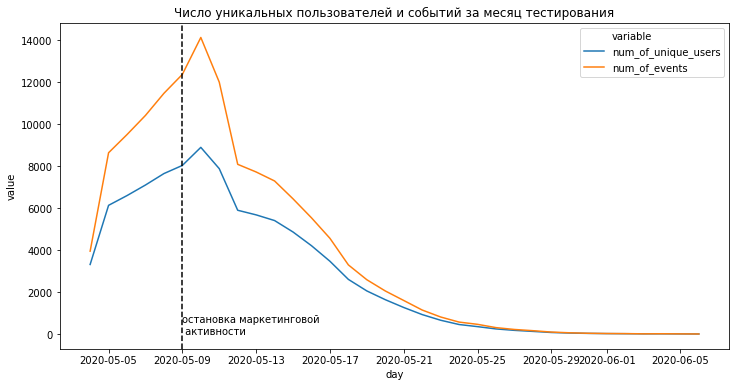

In [25]:
plt.figure(figsize =(12,6))
sns.lineplot(x='day', y ='value', hue='variable', data=events_melt)

plt.axvline('2020-05-09', color='black', linestyle='--') 
plt.text('2020-05-9',0,'остановка маркетинговой \n активности')
plt.title('Число уникальных пользователей и событий за месяц тестирования');

In [26]:
events_grouped.sort_values('num_of_events', ascending=False).head()

,day,num_of_unique_users,num_of_events
6,2020-05-10,8899,14138
5,2020-05-09,8038,12378
7,2020-05-11,7883,12008
4,2020-05-08,7649,11475
3,2020-05-07,7104,10422


Мы видим, что рост числа пользователей продолжался, пока шла маркетинговая активность, и с лагом ы день еще продолжился после окончания (вертикальной линией отмечено окнчание набора новых игроков), и затем резко пошел на спад.

Число событий почти идеально коррелирует с числом уникальных пользователей с определенным мультипликатором, зависящем от активности среднего игрока. По всей видимости, цикл игры первых пользователей начал подходить к концу примерно после 11 числа, что привело к резкому падению и событий, и числа посетителей. Более подробно изучим вопрос, когда доберемся до анализа среднего пользователя.

<a id="step2-1"></a>
### Итоги EDA

Мы проанализировали состав событий и типы построек, обнаружили, что маркетинговая активность по привлечению людей в игру велась с 3 по 9 мая, использовалось 4 источника привлечения графика: фейсбук, инстаграм, яндекс.директ и ютуб. 
Обнаружили, что только треть игроков проходила уровень с помощью "научной" победы, т.е. через постройки.
Также мы проследили уровень активности и число уникальных игроков во времени и составили общее представление о динамике поведения пользователей во время проведения данного исследования: игроки активно приходили с 3го по 10 мая и наращивали количество действий в игре, после чего активность пошла на спад и примерно в середине месяца число игроков уже было ниже средне-дневного значения.

Далее мы займемся подробным анализом действий игроков.

<a id="step3"></a>
### Анализ поведения игроков
[К оглавлению](#step_start)  
1. Составить сводную таблицу по игрокам, содержащую в том числе следующие данные:
    - уникальный ID игрока;
    - закончил игрок уровень или нет;
    - каким способом закончил уровень;
    - когда совершил первое действие;
    - когда совершил последнее действие;
    - общее время прохождения уровня / нахождения в игре (если не закончил);
    - число построенных зданий в разрезе по типам;
    - рекламный источник, по которому игрок пришел в игру.
2. Проанализировать поведение пользоваталей по указанным метрикам - завершение/незавершение уровня, выбор стратегии, время на прохождение уровня. Описать общий портрет среднего игрока.
3. Провести анализ Retention_rate по когортам. В качестве когорт можно взять пользователей, привлеченных в рекламными источниками с 3го по 9ое мая в рамках каждого из дней. 
2. Попробовать найти ответы на следующие вопросы:
    - после какого момента игрока можно считать вовлеченным?
    - как меняется поведение игроков во времени? Можно ли что-то сказать об игровых сессиях или только об уровне в целом?
    - есть ли очевидные различия в поведении пользователей из разных рекламных источников?
    
3. Проверить статистические гипотезы:
    - различается ли время на прохождение уровня одним из двух способов?
    - различаются ли количество зданий между разными способами прохождения?

Начинаем формировать таблицу по игрокам:

In [27]:
#подсчитываем количество построек
players = events.pivot_table(values='event', index='user_id', columns ='building_type', aggfunc='count', dropna=True)
players.fillna(0, inplace=True) 

In [28]:
players['buildings_total'] = players.assembly_shop + players.research_center + players.spaceport

In [29]:
#высчитываем дату завершения уровня 
winners = events[events.event == 'finished_stage_1'].groupby('user_id')['event_datetime'].max().reset_index()
winners.rename(columns={'event_datetime':'win_datetime'}, inplace=True)

In [30]:
players = pd.merge(players, winners, how='left', on='user_id')

In [31]:
#создаем статус прошел/не прошел 
players['level_completed'] = ~players.win_datetime.isna()
players.head()

,user_id,assembly_shop,research_center,spaceport,buildings_total,win_datetime,level_completed
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,6.0,1.0,6.0,13.0,NaT,False
1,00151b4f-ba38-44a8-a650-d7cf130a0105,4.0,0.0,5.0,9.0,NaT,False
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2.0,0.0,2.0,4.0,NaT,False
3,001d39dc-366c-4021-9604-6a3b9ff01e25,4.0,0.0,4.0,8.0,2020-05-12 07:40:47,True
4,002f508f-67b6-479f-814b-b05f00d4e995,3.0,1.0,8.0,12.0,NaT,False


In [32]:
users_builders = events[events.event =='project'].groupby('user_id')['event_datetime'].max().reset_index()
users_builders.rename(columns={'event_datetime':'project_completed_dt'}, inplace=True)

In [33]:
players = pd.merge(players, users_builders, how='left', on='user_id')

In [34]:
#с помощью функции зададим игрокам статус "тип победы" - военная, наука, или nan, если не закончил уровень
def status_mapper(row):
    if row['level_completed'] ==True:
        if pd.isnull(row['project_completed_dt']):
            return 'war'
        else:
            return 'science'
    else:
        return float('nan')

players['win_type'] = players.apply(status_mapper, axis=1)

In [35]:
events_minmax = events.groupby('user_id').agg({'event_datetime':['min', 'max']}).reset_index()
events_minmax.columns = events_minmax.columns.droplevel()
events_minmax.rename(columns = {'' : 'user_id', 'min':'first_event', 'max':'last_event'}, inplace=True)

In [36]:
players = pd.merge(players, events_minmax, how='left', on='user_id')

In [37]:
players['playtime'] = players.last_event - players.first_event

In [38]:
players = pd.merge(players, source, how='left', on='user_id')

Мы получили таблицу по пользователям со всеми их основными характеристиками. Теперь мы можем проанализировать их. Наиболее очевидный подход - это в разрере по выбранной стратегии и по завершению / незавершению уровня.

In [39]:
players.columns

Index(['user_id', 'assembly_shop', 'research_center', 'spaceport',
       'buildings_total', 'win_datetime', 'level_completed',
       'project_completed_dt', 'win_type', 'first_event', 'last_event',
       'playtime', 'source'],
      dtype='object')

In [40]:
players.describe()

,assembly_shop,research_center,spaceport,buildings_total,playtime
count,13576.000000,13576.000000,13576.000000,13576.000000,13576
mean,4.013995,1.041397,4.369844,9.425236,10 days 16:13:07.579183
std,2.001902,1.155553,2.471853,3.860840,4 days 08:24:40.691989
min,1.000000,0.000000,0.000000,1.000000,0 days 00:00:00
25%,2.000000,0.000000,2.000000,6.000000,7 days 16:33:38.750000
50%,4.000000,1.000000,4.000000,10.000000,10 days 12:30:52.500000
75%,6.000000,2.000000,6.000000,12.000000,13 days 07:28:52
max,7.000000,5.000000,10.000000,20.000000,30 days 21:58:53


In [41]:
players_total = players.groupby('level_completed')['user_id'].nunique().reset_index()
total = players_total.user_id.sum()
players_total['% of total'] = round(players_total.user_id / total * 100, 2)
players_total

,level_completed,user_id,% of total
0,False,7759,57.15
1,True,5817,42.85


In [42]:
7759 + 5817

13576

In [43]:
describe_col(players, 'level_completed', ['buildings_total', 'assembly_shop', 'research_center','spaceport', 'playtime'] )

level_completed                        False                    True 
buildings_total mean                 8.65717                  10.4497
                std                  4.13575                  3.18426
                min                        1                        2
                max                       20                       20
assembly_shop   mean                 3.74791                  4.36892
                std                   2.0089                  1.93659
                min                        1                        1
                max                        7                        7
research_center mean                0.861709                  1.28107
                std                   1.1686                  1.09295
                min                        0                        0
                max                        5                        5
spaceport       mean                 4.04756                  4.79972
                std 

Первый уровень завершили 5817 игроков, т.е. 42.8% от всех игравших. Такой игрок в среднем построил 10.5 строений, из них 4,3 сборочных цеха, 1.3 исследовательских центров и 4.8 космопортов. В среднем игроки потратили на прохождение почти 12 дней.
Не закончили уровнеь 7759 игроков, или 57.2% от общего числа. Они построили в среднем 8.6 строений, 3.7 сборочных цеха, меньше одного исследовательского центра и 4 космопорта. Те, кто не завершили уровень, играли в среднем около 10 дней.

In [44]:
players.playtime.describe()

count                      13576
mean     10 days 16:13:07.579183
std       4 days 08:24:40.691989
min              0 days 00:00:00
25%       7 days 16:33:38.750000
50%      10 days 12:30:52.500000
75%             13 days 07:28:52
max             30 days 21:58:53
Name: playtime, dtype: object

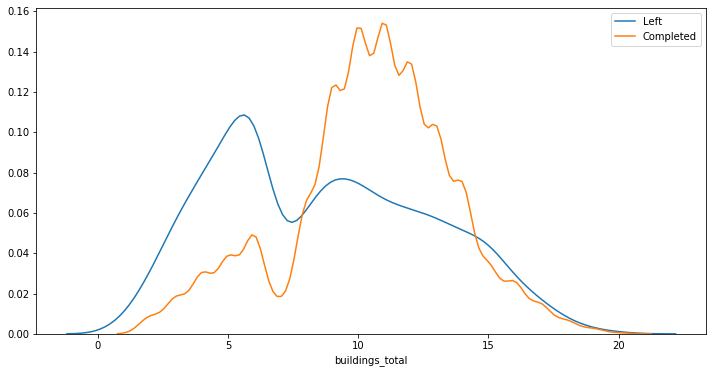

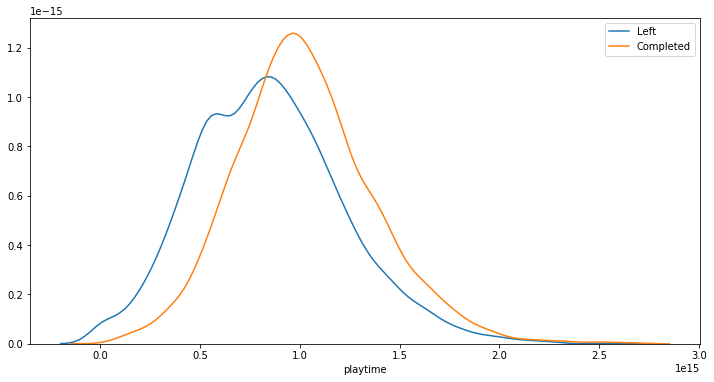

In [45]:
for metric in ['buildings_total', 'playtime']:
    plt.figure(figsize =(12,6))
    sns.distplot(players[players.level_completed==False][metric], hist=False, label='Left')
    sns.distplot(players[players.level_completed==True][metric], hist=False, label ='Completed')
    plt.show()

Вот это интересно: время игры отличается, но не очень заметно, для завершивших форма распределения даже стремится к нормальному.
А вот по количеству построек есть заметная разница в поведении: экстремум среди не закончивших уровень находится на уровне 5 строений, а для завершивших пик - в районе 12-13. 

В распределении числа строений для тех, кто покинул игру, есть два локальных экстремума: я бы это интерпретировал так, что это два экстремумы двух стратегий: в районе 6-7 зданий для тех, кто шел на военную победу, но проиграл /не доиграл, и в районе 9-10 - для тех, кто шел на научную победу.

Возьмем теперь только игроков, завершивших уровень, и сравним характеристики в зависимости от выбранной стратегии:

In [46]:
players_completed = players[players.level_completed == True]

In [47]:
players_completed.groupby('win_type')['user_id'].count()

win_type
science    1866
war        3951
Name: user_id, dtype: int64

Игроков, выбравших научную победу, вдвое меньше, чем военных.

In [48]:
describe_col(players_completed, 'win_type', ['buildings_total', 'assembly_shop', 'research_center','spaceport', 'playtime'] )

win_type                              science                      war
buildings_total mean                  12.6479                  9.41154
                std                   2.16252                  3.05953
                min                        10                        2
                max                        20                       19
assembly_shop   mean                  4.88532                  4.12503
                std                   1.82292                  1.94104
                min                         1                        1
                max                         7                        7
research_center mean                  1.98124                 0.950392
                std                  0.960435                 0.991135
                min                         1                        0
                max                         5                        5
spaceport       mean                  5.78135                  4.33612
      

Можно заметить следующее:
- у военной победы меньше срок игры и больше разброс, потому что речь о взаимодействии двух игроков, больше динамики, но больше и неопределенности;
- для научной победы требуется на треть больше строений: для нее особенно важны исследовательский центр и космопорты. 

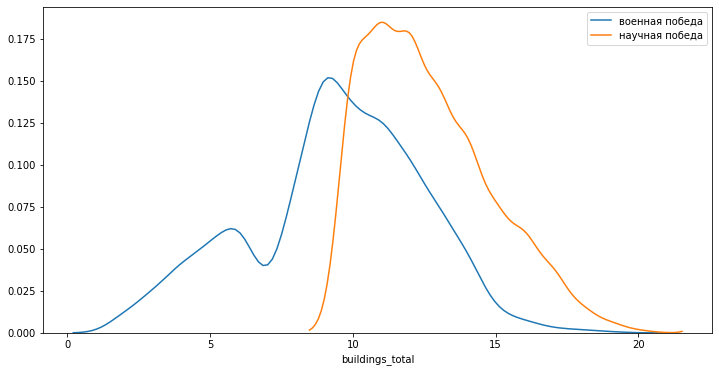

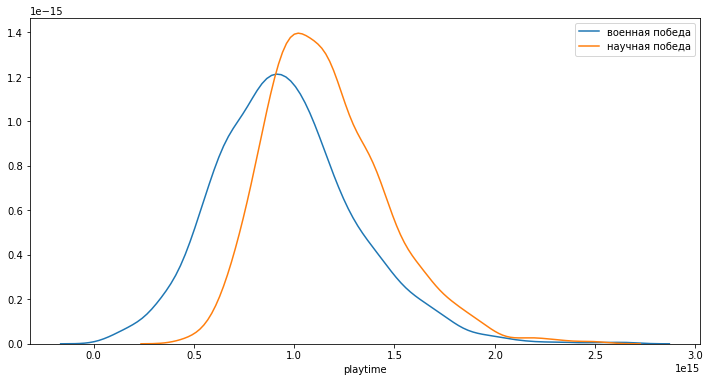

In [49]:
for metric in ['buildings_total', 'playtime']:
    plt.figure(figsize =(12,6))
    sns.distplot(players_completed[players_completed.win_type=='war'][metric], hist=False, label='военная победа')
    sns.distplot(players_completed[players_completed.win_type=='science'][metric], hist=False, label ='научная победа')
    plt.show()

Форма распределения числа строений у военной победы схожа с формой распределения числа строений у тех, кто не выиграл.
Это может значить, что значимая доля тех, кто ушел из игры - придерживались самого начала военной стратегии, но начали проигрывать / проиграли и покинули игру. 
Это выглядит как интересное поле для дополнительных исследований.

Посмотрим на характеристики игроков в разрезе по источникам их привлечения:

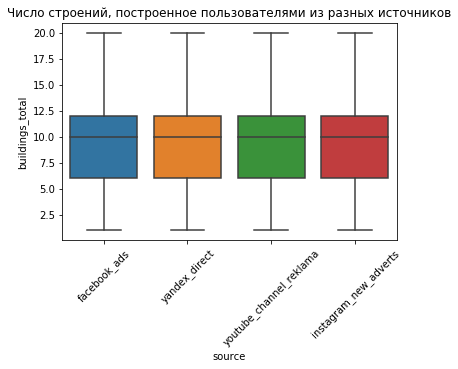

In [50]:
for metric in ['buildings_total']:
    sns.boxplot(x='source', y = metric, data=players)
    plt.xticks(rotation=45)
    plt.title('Число строений, построенное пользователями из разных источников')
    plt.show()
    

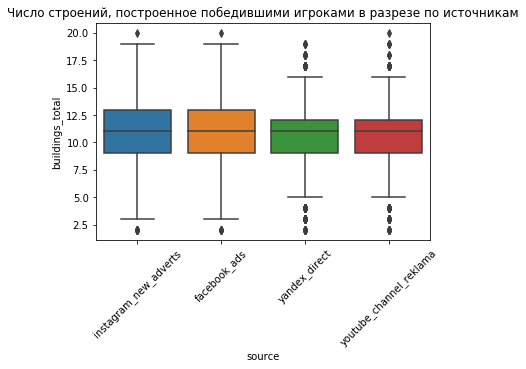

In [51]:
for metric in ['buildings_total']:
    sns.boxplot(x='source', y = metric, data=players_completed)
    plt.xticks(rotation=45)
    plt.title('Число строений, построенное победившими игроками в разрезе по источникам')
    plt.show()

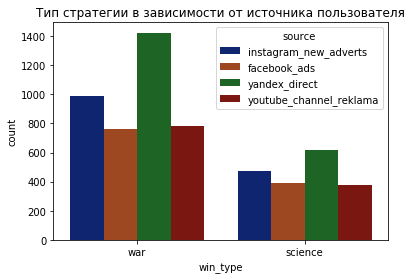

In [52]:
for metric in ['win_type']:
        sns.countplot(metric, data = players_completed, palette= 'dark', hue='source')
        plt.title('Тип стратегии в зависимости от источника пользователя')
        plt.show()

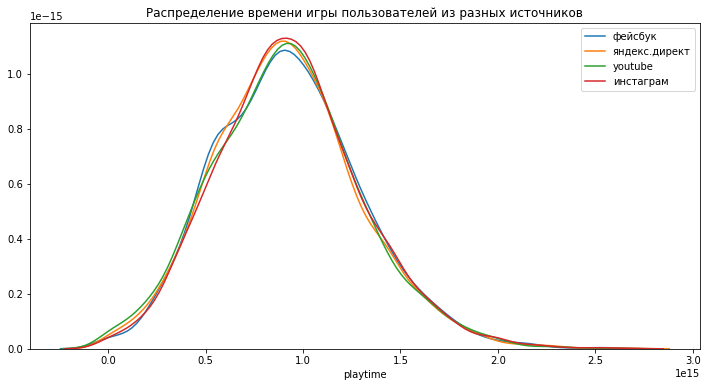

In [53]:
for metric in ['playtime']:
    plt.figure(figsize =(12,6))
    sns.distplot(players[players.source =='facebook_ads'][metric], hist=False, label='фейсбук')
    sns.distplot(players[players.source=='yandex_direct'][metric], hist=False, label ='яндекс.директ')
    sns.distplot(players[players.source=='youtube_channel_reklama'][metric], hist=False, label ='youtube')
    sns.distplot(players[players.source=='instagram_new_adverts'][metric], hist=False, label ='инстаграм')
    plt.title('Распределение времени игры пользователей из разных источников')
    plt.show()

Судя по всему, нет никаких оснований полагать, что поведение пользователей из разных источников как либо отличается. 
Даже на уровне гипотезы это звучит не очень правдоподобно.

Таким образом, мы можем заключить, что с точки зрения поведения нет различий между пользователями, и нам следует ориентироваться только на финансовую эффективность привлечения из разных каналов (с учетом исчерпываемости аудитории).

<a id="step3-0"></a>
### Портреты игроков

Первый уровень завершили 5817 игроков, т.е. 42.8% от всех игравших. Такой игрок в среднем построил 10.5 строений, из них 4,3 сборочных цеха, 1.3 исследовательских центров и 4.8 космопортов. В среднем игроки потратили на прохождение почти 12 дней.
Не закончили уровнеь 7759 игроков, или 57.2% от общего числа. Они построили в среднем 8.6 строений, 3.7 сборочных цеха, меньше одного исследовательского центра и 4 космопорта. Те, кто не завершили уровень, играли в среднем около 10 дней.

Игроки, выигрывшие через "научный" подход, в среднем играли дольше, 13,5 дней. Они построили в среднем 12,6 зданий, и в каждом конкретном здании обошли другую стратегию.
Игроки, выигравшие через военные действия, играли 11 дней, и построили в среднем 9.4 строения. Меньше всего они строили исследовательские центры, вдвое реже, чем выигравшие через науку.

Также мы сделали следующие наблюдения:
- есть некоторые основания полагать, что большинство покинувших игру следовали по пути военной стратегии не преуспели. 
- мы не увидели признаков того, что поведение пользователей или их стратегия различаются в зависимости от источника, по которому они попали в игру.

### Проверка гипотез
Проверим две следующих гипотезы:
    - различается ли среднее время на прохождение уровня одним из двух способов?
    - различаются ли среднее  количество зданий между разными способами прохождения?
Мы будем тестировать на совпадение средние значения двух генеральных совокупностей. Поскольку выборочные средние распределены нормально в соответствии с центральной предельной теоремой, нам не требуется делать проверку нормальность или прибегать к непараметрическим тестам. Сделаем расчет чере t-тест.

Поскольку мы тестируем две гипотезы, сделаем поправку Бонферрони.

In [54]:
alpha = 0.05 / 2 

In [55]:
players_science = players[players.win_type =='science'][['playtime', 'buildings_total' ]]

In [56]:
players_war =  players[players.win_type =='war'][['playtime', 'buildings_total' ]]

Тестируем гипотезу о среднем времени прохождения уровня.

**Нулевая гипотеза**: не существует значимой разницы в среднем времени прохождения уровня между разными стратегиями.

**Альтернативная гипотеза**: время прохождения уровня разными способами значимо отличаются.

Переведем время игры в часы, чтобы тест нормально отработал:

In [57]:
players_science['playtime_h'] =  players_science.playtime / np.timedelta64(1, 'h')

players_war['playtime_h'] =  players_war.playtime / np.timedelta64(1, 'h')

In [58]:
results = st.ttest_ind (players_science.playtime_h, players_war.playtime_h )

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 7.256845329498955e-98
Отвергаем нулевую гипотезу


Тестируем гипотезу о среднем количестве зданий.

**Нулевая гипотеза**: не существует значимой разницы в среднем числе зданий, которые игроки строили в рамках разных стратегий.

**Альтернативная гипотеза**: среднее число построенных зданий в разных стратегиях значимо отличается.

In [59]:
results = st.ttest_ind (players_science.buildings_total, players_war.buildings_total )

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0
Отвергаем нулевую гипотезу


<a id="hypothesis"></a>
#### Результаты проверки гипотез

В обоих случаях число p очень мало, и мы должны отвергнуть нулевую гипотезу об отсутствии различий.
Мы имеем все основания полагать, что поведение игроков при разных стратегиях и время их игры значимо отличается.

<a id="retention"></a>
### Анализ Retention Rate и Churn Rate по когортам

In [60]:
players['first_event_day']= players.first_event.dt.round('D')

In [61]:
players.groupby(['first_event_day'])['user_id'].count()

first_event_day
2020-05-04    3315
2020-05-05    4454
2020-05-06    2464
2020-05-07    1445
2020-05-08     894
2020-05-09     532
2020-05-10     338
2020-05-11     134
Name: user_id, dtype: int64

Есть небольшая проблема, связанная с тем, что даты первых событий смещены относительно дат привлечений пользователей - маркетинговая активность была с 3 по 9 мая, а у нас тут дневные когорты с 4 по 11 число.
Также проблема в том, что когорты слишком разного размера: получатся более шумные графики.

Я бы категоризировал данные в несколько сопоставимых когорт, например, объединил бы данные 6 и 7 числа в третью когорту, а с 8 по 11 - в четвертую.

In [62]:
dict_mapper = {
        pd.to_datetime('2020-05-04'):0,
        pd.to_datetime('2020-05-05'):1,
        pd.to_datetime('2020-05-06'):2,
        pd.to_datetime('2020-05-07'):2,
        pd.to_datetime('2020-05-08'):3,
        pd.to_datetime('2020-05-09'):3,
        pd.to_datetime('2020-05-10'):3,
        pd.to_datetime('2020-05-11'):3
}
players['cohort'] = players.first_event_day.map(dict_mapper)

In [63]:
events = events.merge(players[['user_id', 'first_event_day', 'cohort']],  how='left', on='user_id')

In [64]:
events['event_day'] = events.event_datetime.dt.round('d')


In [65]:
events['lifetime'] = events.event_day - events.first_event_day
events['lifetime'] = (events['lifetime'] / np.timedelta64(1,'D')).round().astype('int')

In [66]:
cohorts = events.groupby(['cohort','lifetime']).agg({'user_id':'nunique'}).reset_index()

In [67]:
initial_users = cohorts[cohorts.lifetime==0][['cohort', 'user_id']]
initial_users.columns = ['cohort', 'initial_users']
cohorts = cohorts.merge(initial_users, on = 'cohort')

In [68]:
cohorts['retention_rate'] = cohorts.user_id / cohorts.initial_users

Ограничим число дней в когортном анализе 20: это средний срок прохождения уровня + 2 стандартных отклонения сверху. Данные длинного хвоста нам не так интересны и только будут смазывать картину поведения в первые дни.

<div class="alert alert-block alert-success">
    
    
### Комментарий от тимлида   
Согласна. Хвост уже мало нас интересует. Особенно учитывая, что через 20 дней большинство уже прошло первый уровень, а данных о втором у нас нет
</div>

In [69]:
cohorts_pivot = cohorts[cohorts.lifetime<21].pivot(index = 'cohort', columns = 'lifetime', values = 'retention_rate')

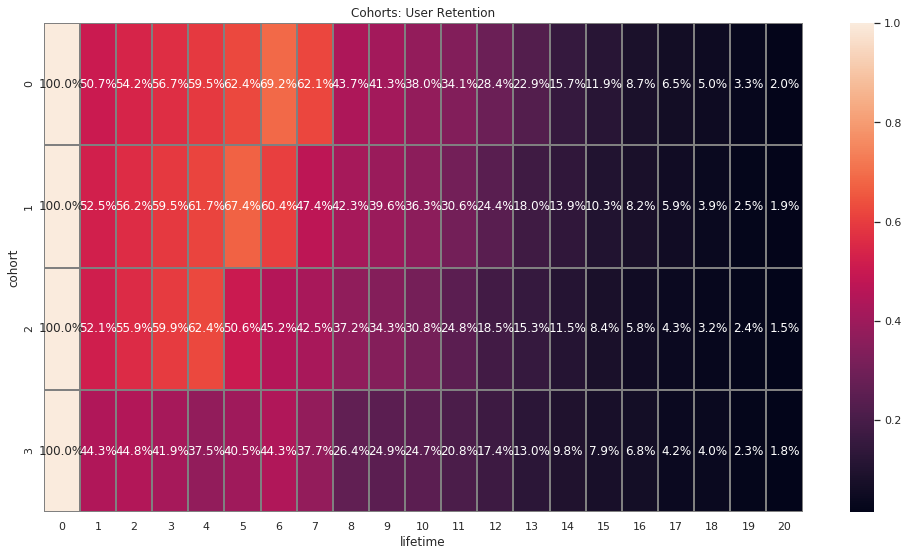

In [70]:
sns.set(style='white')
plt.figure(figsize=(17, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(cohorts_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')

Получается интересная картина:
- после значительного падения (50%) в первый день, следующие несколько дней (3-6) количество уникальных игроков в день **растет**. 
- интересный эффект: **в каждой следующей когорте уровень интереса теряется все быстрее**. Поскольку игра не менялась, я думаю, дело в том, что в более поздние когорты у нас вошли в том числе люди, которые не то что позднее увидели рекламное объявление, а позже присоединились, т.е. **имели большой лаг между показом объявления/регистрацией и первым действием в игре**. Скорее всего этот лаг является **маркером пониженного интереса**, который также проявляется в более быстрой потере интереса. Я думаю, если бы у нас был более надежный способ идентифицировать игроков по когортам (было бы действие регистрации, например), мы смогли бы этот эффект проанализировать подробней.

Поскольку наша базовая идея - показ рекламы на экране постройки, посмотрим на **churn rate по количеству построенных зданий** - может, это даст нам дополнительные идеи?

In [71]:
events['building_number'] = events[events.event =='building'].groupby('user_id')['event_datetime'].cumcount()

In [72]:
events.head()

,event_datetime,event,building_type,user_id,project_type,day,first_event_day,cohort,event_day,lifetime,building_number
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04,2020-05-04,0,2020-05-04,0,0.0
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,2020-05-04,2020-05-04,0,2020-05-04,0,0.0
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,2020-05-04,2020-05-04,0,2020-05-04,0,0.0
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,2020-05-04,2020-05-04,0,2020-05-04,0,0.0
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,2020-05-04,2020-05-04,0,2020-05-04,0,0.0


In [73]:
cohorts_b = events.groupby(['cohort','building_number']).agg({'user_id':'nunique'}).reset_index()

In [74]:
initial_users = cohorts_b[cohorts_b.building_number==0][['cohort', 'user_id']]
initial_users.columns = ['cohort', 'initial_users']
cohorts_b = cohorts_b.merge(initial_users, on = 'cohort')

In [75]:
cohorts_b['retention_rate'] = cohorts_b.user_id / cohorts_b.initial_users

In [76]:
cohorts_b['churn_rate'] = cohorts_b.groupby(['cohort'])['user_id'].pct_change() 

Ограничим число строений в когортном анализе шестандцатью включительно: это среднее число построек плюс два стандартных отклонения сверху.

In [77]:
cohorts_pivot_b = cohorts_b[cohorts_b.building_number<17].pivot(index = 'cohort', columns = 'building_number', values = 'churn_rate')

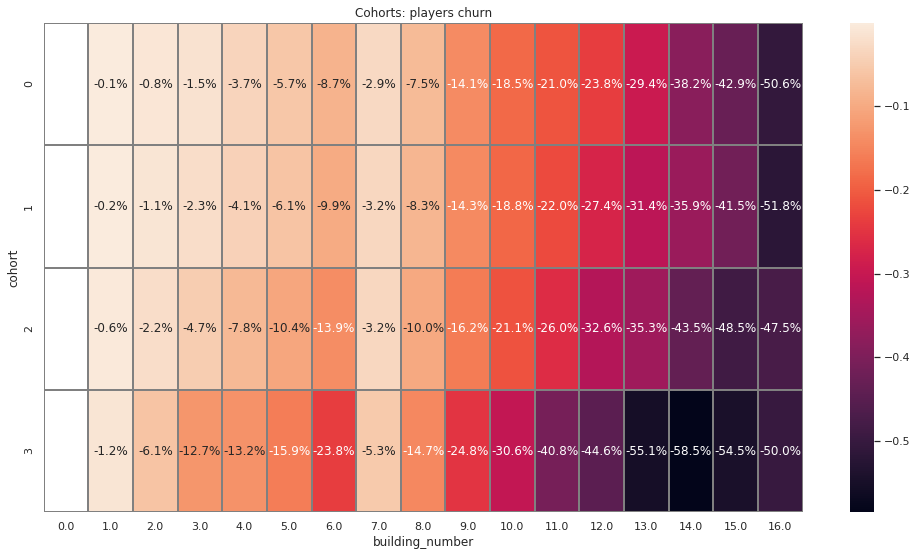

In [78]:
sns.set(style='white')
plt.figure(figsize=(17, 9))
plt.title('Cohorts: players churn')
sns.heatmap(cohorts_pivot_b, annot=True, fmt='.1%', linewidths=1, linecolor='gray')

Довольно интересная ситуация: с 1 по 6 здание сохраняется плавный отток в средних значениях, а затем в переходе от 6го здания до 7го отток резко снижается. Как мы помним по графику, 7 зданий - самое частотное значение для тех, кто покинул игру / проиграл. 
Я бы это интерпертировал так, что в районе 6-7 здания происходит геймплейный перелом в игре на военную победу: в ситуации конфронтации определяется явный лидер, и игрок либо понимает, что выигрывает, и его вовлеченность растет, либо он проигрывает по военной стратегии и уходит до этого момента.

<div class="alert alert-block alert-success">
    
    
### Комментарий от тимлида   
Крутой хитмап - хорошо видно снижение оттока на 7 день. а помнишь, я в начале проекта спрашивала про просадку? Вот и добрались))
</div>

Посмотрим на число строений, построенных в среднем в день, в динамике, в разрезе по победе/проигрышу и типу победы.

In [79]:
events = events.merge(players[['user_id', 'level_completed', 'win_type']], how='left',  on='user_id')

In [80]:
events.win_type.fillna('left', inplace=True)

In [81]:
buildings_daily = events[events.event=='building'].groupby(['event_day', 'level_completed']).agg({'event':'count','user_id':'nunique'})

In [82]:
buildings_daily['built'] = buildings_daily.event / buildings_daily.user_id
buildings_daily.reset_index(inplace=True)

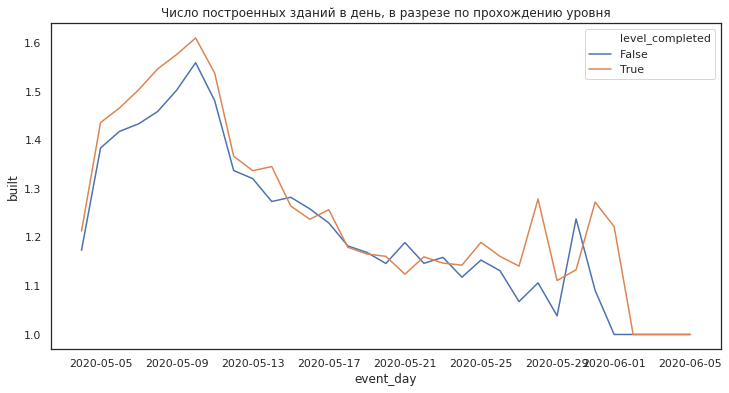

In [83]:
plt.figure(figsize =(12,6))
plt.title('Число построенных зданий в день, в разрезе по прохождению уровня')
sns.lineplot(x='event_day', y ='built', hue='level_completed', data=buildings_daily)

In [84]:
buildings_strategy = events[events.event=='building'].groupby(['event_day', 'win_type']).agg({'event':'count','user_id':'nunique'})
buildings_strategy['built'] = buildings_strategy.event / buildings_strategy.user_id
buildings_strategy.reset_index(inplace=True)

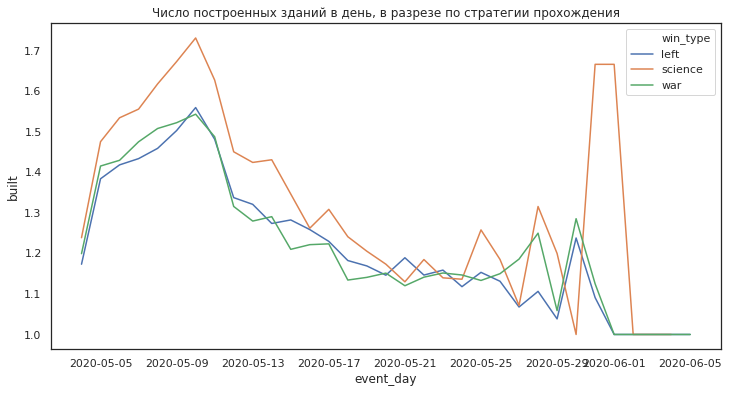

In [85]:
plt.figure(figsize =(12,6))
plt.title('Число построенных зданий в день, в разрезе по стратегии прохождения')
sns.lineplot(x='event_day', y ='built', hue='win_type', data=buildings_strategy)

<a id="step3-1"></a>
### Результаты анализа поведения игроков

Похоже, игроки, идущие на научную победу, с самого начала строят больше, а у тех, кто воюет, часть ресурсов уходит на военные расходы. Экстремум числа построек случился синхронно у всех типов стратегий, но проигрывашие строили несколько меньше тех, кто выиграл через победу - вероятно, в этом и заключалась разница. 

Есть шанс, что по нескольким первым дням можно определить тип победы, на которую идет игрок, и выбрать подходящую для него модель монетизации. 
У нас мало данных и времени для проведения подобного анализа, поэтому остановимся на следующем, условно-близком, заключении:
- тот, кто идет на военную победу, быстрее вовлекается, быстрее завершает уровень и меньше строит. Ему следует показывать рекламу несколько раньше;
- тот, кто идет на научную победу, строит больше, дольше играет, но мы не можем судить о том, насколько он вовлечен, только предположить, что в отсутствие активной конкуренции вовлеченность происходит медленнее. 

Я бы рекомендовал использовать функцию, которая определяет, когда начинать показывать рекламу, в зависимости от того, какое событие наступает раньше: n-ый день игры или n-ое построенное здание. Подбор функции также потребует тестирования, но мы можем оттолкнуться от имеющихся паттернов и предложить определенный вариант. Подберем конкретные параметры позже. 


<a id="step4"></a>
### Анализ расходов и анализ возможных путей монетизации
[К оглавлению](#step_start)  
1. Посчитать среднюю стоимость привлечения клиента CAC в разрезе по источникам привлечения;
2. Частично применить фреймворк AARRR, а именно:
    - сделать выводы по Acquisition, источникам привлечения, какие источники наиболее перспективные;
    - выводы по Retention, как можно охарактеризовать структуру удержания/оттока игроков?
    - выводы по Revenue:
        каким образом можно оптимизировать затраты на привлечение игроков?
        какую рекламу, где и когда показывать игрокам?
3. Сделать общие выводы: уточненный портрет игрока, в разрезе по стратегиям и по источникам трафика. Дать общие рекомендации по возможным стратегиям монетизации, работе с привлечением игроков и их удержанием. 

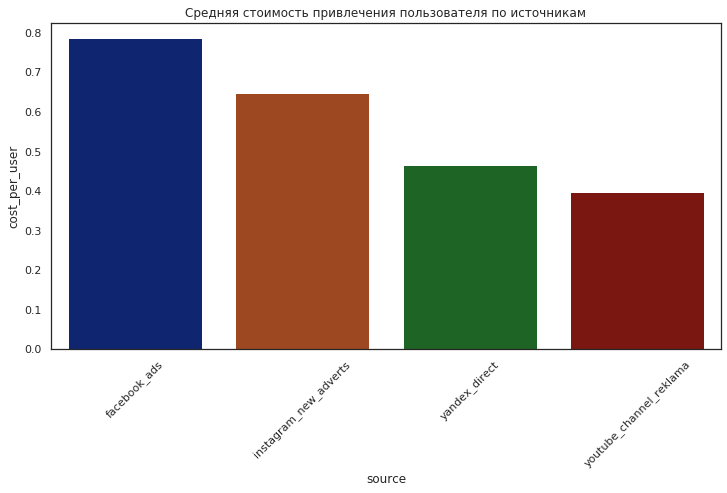

In [86]:
source_grouped = pd.DataFrame(source.groupby('source')['user_id'].nunique().reset_index())

costs_grouped =  pd.DataFrame(costs.groupby('source')['cost'].sum().reset_index())

costs_grouped =costs_grouped.merge(source_grouped, on='source')

costs_grouped['cost_per_user'] = costs_grouped.cost / costs_grouped.user_id

plt.figure(figsize =(12,6))
sns.barplot('source', 'cost_per_user', data = costs_grouped, palette= 'dark')
plt.title('Средняя стоимость привлечения пользователя по источникам')
plt.xticks(rotation=45);

In [87]:
costs_grouped

,source,cost,user_id,cost_per_user
0,facebook_ads,2140.904643,2726,0.785365
1,instagram_new_adverts,2161.441691,3347,0.645785
2,yandex_direct,2233.111449,4817,0.463590
3,youtube_channel_reklama,1068.119204,2686,0.397662


Источники достаточно сильно различаются по стоимости привлечения пользователей, при этом в нашем предыдущем анализе мы не обнаружили различий в поведении игроков из разных источников. Так что при выборе числа источников их их стоимости следует ориентироваться исключительно на оценки маркетологов по исчерпываемости целевой аудитории по указанным каналам и по максимуму использовать ресурс более дешевых источников.


Наш общий вывод по монетизации: в зависимости от темпа, в которой игрок строит, и стратегии, которую он выбрал, следует показывать рекламу либо не раньше определенного дня игры, либо не раньше определенного по счёту числа здания, в зависимости от того, какой этап наступит раньше.

Построим грубую модель расчёта возможной окупаемости. Будем исходить из ряда довольно грубых предположений:
- поскольку мы не сразу начинаем показывать рекламу, поведения пользователей не меняется;
- lifetime value расчитываем исходя из одного уровня;
- протестируем простую монетизацию через показ баннеров: это дешевый способ, но он не требует предпложений о clickrate, которые мы не можем обоснованно сделать;
- предположим, что цены на привлечение игроков у нас в долларах. 
- возьмем за выручку с показа баннера показатель $0.14
- предположим, что мы начинаем показ рекламы либо на 3 день игры, либо с пятого строения, смотря, что наступит раньше.

Внесем параметры в переменные для возможного тестирования сценариев в будущем.

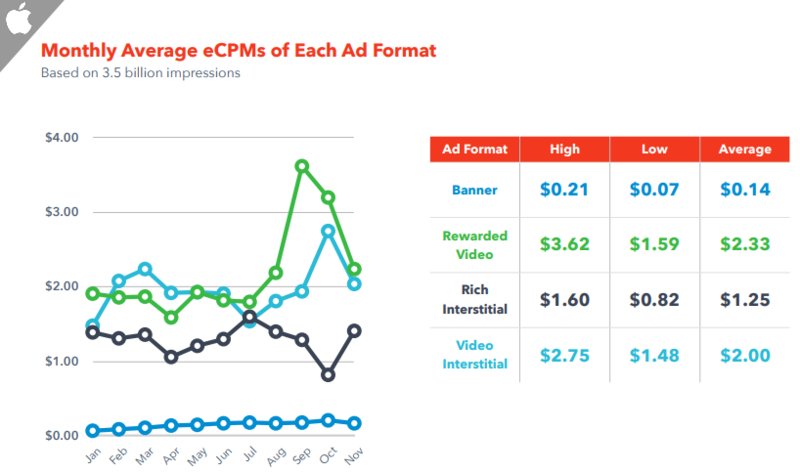

In [88]:
banner_revenue = 0.14
day_threshold = 3
building_threshold = 5

In [89]:
def monetize_event(row):
    '''
    Функция строки для apply(axis=1), возвращает True, если в соответствии с моделью надо монетизировать действие,
    и False, если нет.
    'event' - тип события, на котором предполагается монетизация, срабатывает на building
    'lifetime' - день события для пользователя
    'building_number' - порядковый номер строения для данного пользователя
    '''
    if row['event'] == 'building':
        if row['lifetime'] >= day_threshold or row['building_number'] >=building_threshold:
            return True
        else:
            return False
    else:
        return False

In [90]:
events['monetize_event'] = events.apply(monetize_event, axis=1)

In [91]:
events['revenue'] = events.monetize_event * banner_revenue

Построим когорты по всем пользователям в разрезе по источникам трафика:

In [92]:
events = events.merge(source, how='left', on = 'user_id')

In [93]:
cohorts = events.groupby(['source','lifetime']).agg({'revenue': 'sum'}).reset_index()

In [94]:
costs_grouped

,source,cost,user_id,cost_per_user
0,facebook_ads,2140.904643,2726,0.785365
1,instagram_new_adverts,2161.441691,3347,0.645785
2,yandex_direct,2233.111449,4817,0.463590
3,youtube_channel_reklama,1068.119204,2686,0.397662


In [95]:
cohorts = cohorts.merge(costs_grouped[['source', 'user_id', 'cost_per_user']], how='left', on='source')


In [96]:
cohorts['ltv'] = cohorts['revenue'] / cohorts['user_id']

In [97]:
cohorts['romi'] = cohorts['ltv'] / cohorts['cost_per_user']

Ограничим output 20 днями из той же логики, что и раньше: среднее время прохождения + 2 std

In [98]:
output = cohorts[cohorts.lifetime<=20].pivot_table(
        index='source', 
        columns='lifetime', 
        values='romi', 
        aggfunc='mean')

pd.set_option('display.max_columns',None)
output.cumsum(axis=1).round(2) 

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
source,,,,,,,,,,,,,,,,,,,,,
facebook_ads,0.0,0.0,0.01,0.17,0.32,0.49,0.64,0.76,0.85,0.93,1.00,1.05,1.09,1.12,1.15,1.16,1.17,1.18,1.19,1.19,1.20
instagram_new_adverts,0.0,0.0,0.02,0.20,0.39,0.58,0.76,0.91,1.02,1.12,1.20,1.27,1.32,1.36,1.39,1.41,1.42,1.43,1.44,1.44,1.45
yandex_direct,0.0,0.0,0.02,0.28,0.54,0.80,1.05,1.25,1.40,1.53,1.64,1.74,1.81,1.86,1.89,1.92,1.94,1.95,1.96,1.97,1.97
youtube_channel_reklama,0.0,0.0,0.03,0.32,0.63,0.94,1.22,1.45,1.62,1.78,1.91,2.01,2.10,2.15,2.20,2.23,2.25,2.27,2.28,2.29,2.29


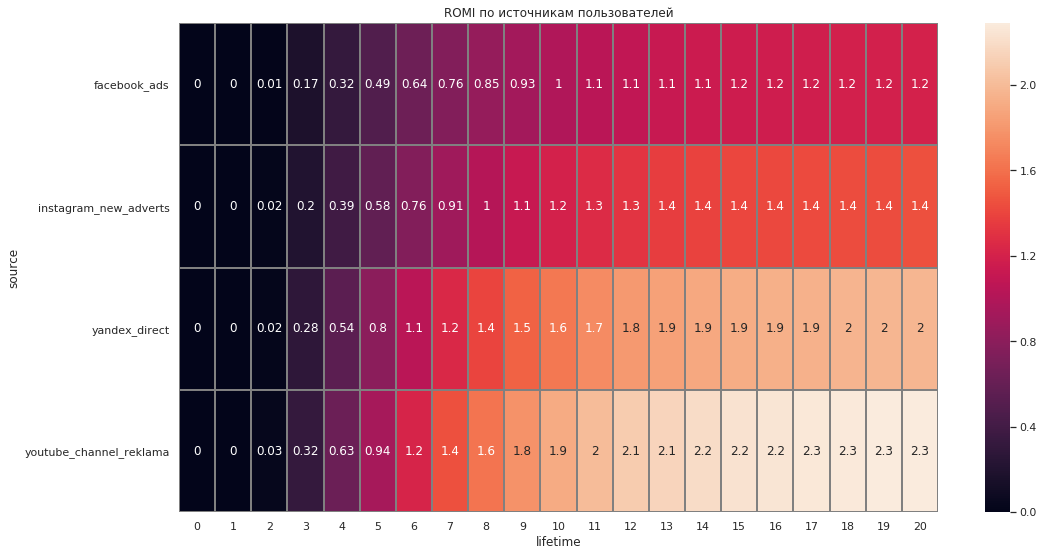

In [99]:
sns.set(style='white')
plt.figure(figsize=(17, 9))
plt.title('ROMI по источникам пользователей')
sns.heatmap(output.cumsum(axis=1).round(2) , annot=True, linewidths=1, linecolor='gray')

В базовом виде наша грубая модель показывает себя неплохо. На 9 день, когда в среднем те, кто проигрывают, заканчивают игру, привлечение уже окупаются (иногда с хорошим запасом) пользователи из всех источников, кроме Facebook. 
На 11-13 день, средний срок игры в двух наших основных стратегиях, уже все расходы окупились, причем по эффективным источникам - yandex.direct и youtube - почти вдвое. 
Даже если предположить, что пользователи будут недовольны баннерами и случится небольшой отток, при эффективном выборе источников привлечения мы как минимум не уйдем в минус.

Возможно, баланс условий модели далек от идеального, либо не стоит использовать фактор числа строений: в данной модели, как мы видим, на 1-2 день значимой монетизации не происходит.

<a id="step4-1"></a>
### Общие выводы и рекомендации
[К оглавлению](#step_start)  

В целом после изучения информации можно заключить и рекомендовать следующее:
- изучить необходимость выравнивания характеристик среднего прохождения по стратегиям. Большинство игроков выбирают военный подход, который короче и с точки зрения достижения победы, и явно влияет на срок незавершения уровня проигравшими в военном соревновании. "Научный" подход выглядит более выгодным для нас, поэтому имеет смысл подтакливать игроков к нему;
- использовать в качестве основных источников новых игроков yandex.direct и youtube. Мы не выявили разницы в поведении между игроками разных источников, при этом маркетинговые средства расходуются эффективней. 
- мы рекомендуем протестировать гипотезу о следующей модели монетизации: включать рекламу на третий день игры или начиная с 5го строения, смотря, что произойдет раньше. 
- теоретическая модель на исторических данных показывает удовлетворительные результаты. 